In [1]:
import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# --- 1. 配置 ---
# 👇 只需修改这里，指定要分析的问题 QID
TARGET_QID = 19

# --- 2. 将工作目录设置为项目根目录 (如果需要) ---
os.chdir(os.path.expanduser('~/Projects/Method/deepconf'))

# --- 3. Robust Data Loading Function ---
def load_concatenated_json(file_path):
    """
    Reads a file containing one or more concatenated JSON objects
    and merges them into a single, valid data structure.
    """
    decoder = json.JSONDecoder()
    data_parts = []
    
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
        idx = 0
        while idx < len(content):
            while idx < len(content) and content[idx].isspace():
                idx += 1
            if idx == len(content):
                break
            try:
                obj, end = decoder.raw_decode(content, idx)
                data_parts.append(obj)
                idx = end
            except json.JSONDecodeError:
                break

    if not data_parts:
        return None

    # Merge the parts
    final_data = {k: v for k, v in data_parts[0].items() if k != 'traces'}
    all_traces = [trace for part in data_parts for trace in part.get('traces', [])]
    
    final_data['traces'] = all_traces
    final_data['num_traces'] = len(all_traces)
    
    return final_data

# --- 4. Load the Target File ---
file_path = f'trace_data/aime_2025_{TARGET_QID}_full.jsonl'
data = load_concatenated_json(file_path)

if data:
    traces = data.get('traces', [])
    print(f"\nSuccessfully loaded and merged data for QID {TARGET_QID}.")
    print(f"Total traces found: {len(traces)}")
else:
    print(f"\nERROR: Could not load data from {file_path}")
    traces = []


Successfully loaded and merged data for QID 19.
Total traces found: 256


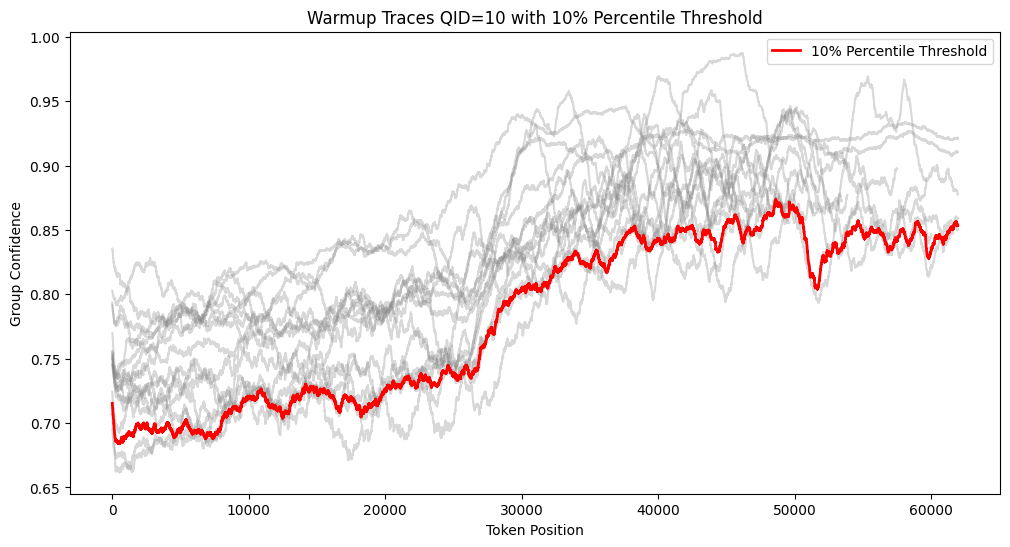

In [14]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- 配置 ---
WARMUP_DIR = 'trace_data_3/warmup_data'
TARGET_QID = 10  # 需要分析的 question

# --- Robust Data Loading Function (同你之前用的) ---
# def load_concatenated_json(file_path):
#     decoder = json.JSONDecoder()
#     data_parts = []
#     with open(file_path, 'r', encoding='utf-8') as f:
#         content = f.read()
#         idx = 0
#         while idx < len(content):
#             while idx < len(content) and content[idx].isspace():
#                 idx += 1
#             if idx == len(content):
#                 break
#             try:
#                 obj, end = decoder.raw_decode(content, idx)
#                 data_parts.append(obj)
#                 idx = end
#             except json.JSONDecodeError:
#                 break
#     if not data_parts:
#         return None
#     final_data = {k: v for k, v in data_parts[0].items() if k != 'traces'}
#     all_traces = [trace for part in data_parts for trace in part.get('traces', [])]
#     final_data['traces'] = all_traces
#     final_data['num_traces'] = len(all_traces)
#     return final_data
# import json

def load_jsonl(file_path):
    """
    Loads data from a standard JSONL file where each line is a
    separate JSON object.

    Args:
        file_path (str): The path to the JSONL file.

    Returns:
        list: A list of Python dictionaries, where each dictionary
              corresponds to a line in the JSONL file.
    """
    data = []
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line_number, line in enumerate(f, 1):
                # 移除行尾可能存在的换行符和空白符
                line = line.strip()
                # 如果是空行，则跳过
                if not line:
                    continue
                try:
                    # 解析当前行作为一个独立的 JSON 对象
                    json_object = json.loads(line)
                    data.append(json_object)
                except json.JSONDecodeError as e:
                    # 如果某一行解析失败，打印错误信息并继续处理下一行
                    print(f"警告：无法解析文件 {file_path} 中的第 {line_number} 行: {e}")
                    print(f"   问题行内容: {line[:100]}...") # 打印问题行的开头部分
                    continue
        return data
    except FileNotFoundError:
        print(f"错误：文件未找到于 {file_path}")
        return []
    except Exception as e:
        print(f"读取文件 {file_path} 时发生未知错误: {e}")
        return []
# --- 加载 warmup traces ---
warmup_file = os.path.join(WARMUP_DIR, f'aime_2025_{TARGET_QID}_warmup.jsonl')
traces = load_jsonl(warmup_file)
if not traces:
    raise ValueError(f"无法加载 warmup traces: {warmup_file}")

# --- 对齐 trace lengths ---
max_len = max(len(trace['group_confidence']) for trace in traces)
all_conf_matrix = np.full((len(traces), max_len), np.nan)
for i, trace in enumerate(traces):
    l = len(trace['group_confidence'])
    all_conf_matrix[i, :l] = trace['group_confidence']

# --- 计算每个横坐标位置的 10% 分位数折线 ---
percentile_line = np.nanpercentile(all_conf_matrix, 10, axis=0)

# --- 可视化 ---
plt.figure(figsize=(12, 6))
for trace in traces:
    plt.plot(trace['group_confidence'], color='gray', alpha=0.3)
plt.plot(percentile_line, color='red', linewidth=2, label='10% Percentile Threshold')
plt.xlabel('Token Position')
plt.ylabel('Group Confidence')
plt.title(f'Warmup Traces QID={TARGET_QID} with 10% Percentile Threshold')
plt.legend()
plt.show()



49581


/tmp/ipykernel_1742076/250572500.py:82: RuntimeWarning: All-NaN slice encountered
  y_pred.append(1 if np.nanmax(screened_confs) > 0 else 0)  # 被截断=0，否则=1


ValueError: operands could not be broadcast together with shapes (61309,) (49581,) 

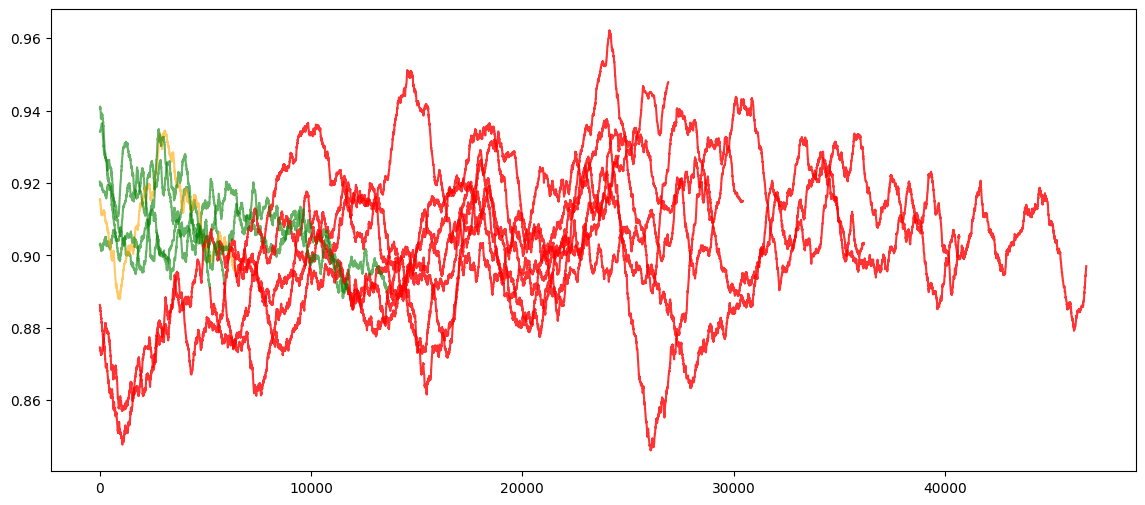

In [5]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
os.chdir(os.path.expanduser('~/Projects/Method/deepconf'))
# --- 配置 ---
WARMUP_DIR = 'trace_data/warmup_data'
TARGET_QID = 11  # 要分析的问题

# --- Robust Data Loading Function ---
def load_concatenated_json(file_path):
    decoder = json.JSONDecoder()
    data_parts = []
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
        idx = 0
        while idx < len(content):
            while idx < len(content) and content[idx].isspace():
                idx += 1
            if idx == len(content):
                break
            try:
                obj, end = decoder.raw_decode(content, idx)
                data_parts.append(obj)
                idx = end
            except json.JSONDecodeError:
                break
    if not data_parts:
        return None
    final_data = {k: v for k, v in data_parts[0].items() if k != 'traces'}
    all_traces = [trace for part in data_parts for trace in part.get('traces', [])]
    final_data['traces'] = all_traces
    final_data['num_traces'] = len(all_traces)
    return final_data

# --- 1. 加载 warmup traces 并计算 percentile 折线 ---
warmup_file = os.path.join(WARMUP_DIR, f'aime_2025_{TARGET_QID}_warmup.jsonl')
warmup_data = load_concatenated_json(warmup_file)
if not warmup_data:
    raise ValueError(f"无法加载 warmup traces: {warmup_file}")
warmup_traces = warmup_data['traces']

# 对齐长度
max_len = max(len(trace['group_confidence']) for trace in warmup_traces)
warmup_matrix = np.full((len(warmup_traces), max_len), np.nan)
for i, trace in enumerate(warmup_traces):
    l = len(trace['group_confidence'])
    warmup_matrix[i, :l] = trace['group_confidence']

# 计算每个横坐标的 10% 分位数折线
threshold_line = np.nanpercentile(warmup_matrix, 10, axis=0)
print(len(threshold_line))
# --- 2. 加载目标 QID traces ---
trace_file = f'trace_data/aime_2025_{TARGET_QID}_full.jsonl'
data = load_concatenated_json(trace_file)
if not data:
    raise ValueError(f"无法加载目标 traces: {trace_file}")
traces = data['traces']

# --- 3. Screening: 低于折线的部分截掉 ---
y_true = []
y_pred = []

plt.figure(figsize=(14, 6))
for trace in traces:
    confs = np.array(trace['group_confidence'])
    trace_len = len(confs)
    threshold = threshold_line[:trace_len]
    # 找到第一次低于 threshold 的位置
    cutoff_idx = np.argmax(confs < threshold)
    if cutoff_idx == 0 and confs[0] >= threshold[0]:
        cutoff_idx = trace_len  # 没有被截断
    
    # 分类: 被截断即为负样本
    screened_confs = confs.copy()
    screened_confs[cutoff_idx:] = np.nan
    
    # 根据 ground truth 标颜色
    color = 'green' if trace['is_correct'] else 'orange'
    y_true.append(int(trace['is_correct']))
    y_pred.append(1 if np.nanmax(screened_confs) > 0 else 0)  # 被截断=0，否则=1
    
    # 绘制曲线
    plt.plot(range(trace_len), screened_confs, color=color, alpha=0.6)
    if cutoff_idx < trace_len:
        plt.plot(range(cutoff_idx, trace_len), confs[cutoff_idx:], color='red', alpha=0.8)

plt.plot(range(len(threshold_line)), threshold_line, color='blue', linewidth=2, label='10% Percentile Threshold')
plt.xlabel('Token Position')
plt.ylabel('Group Confidence')
plt.title(f'Traces with Screening based on Percentile Threshold QID={TARGET_QID}')
plt.show()

# --- 4. 输出混淆矩阵 ---
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Predicted Cut', 'Predicted Keep'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix: Screening vs True Correctness')
plt.show()

print("混淆矩阵 (行=实际, 列=预测):")
print(cm)


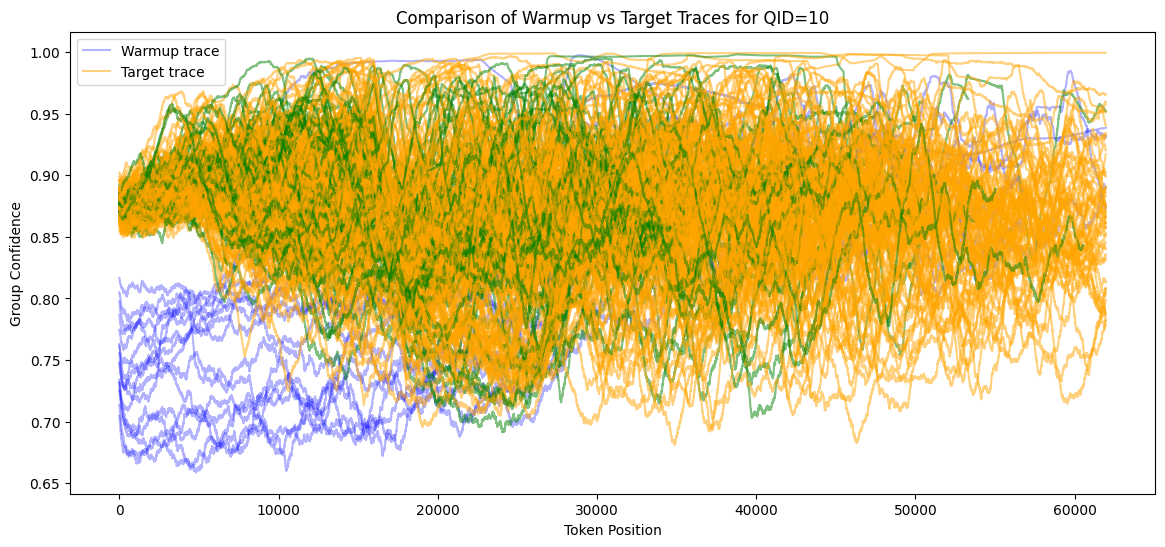

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# --- 配置 ---
WARMUP_DIR = 'trace_data_3/warmup_data'
TRACE_DIR = 'trace_data'
TARGET_QID = 10  # 指定要检查的 QID

# --- Robust Data Loading Function ---
def load_concatenated_json(file_path):
    decoder = json.JSONDecoder()
    data_parts = []
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
        idx = 0
        while idx < len(content):
            while idx < len(content) and content[idx].isspace():
                idx += 1
            if idx == len(content):
                break
            try:
                obj, end = decoder.raw_decode(content, idx)
                data_parts.append(obj)
                idx = end
            except json.JSONDecodeError:
                print('error')
                break
    if not data_parts:
        return None
    final_data = {k: v for k, v in data_parts[0].items() if k != 'traces'}
    all_traces = [trace for part in data_parts for trace in part.get('traces', [])]
    final_data['traces'] = all_traces
    final_data['num_traces'] = len(all_traces)
    return final_data

# --- 1. 加载 warmup traces ---
warmup_file = os.path.join(WARMUP_DIR, f'aime_2025_{TARGET_QID}_warmup.jsonl')
warmup_data = load_concatenated_json(warmup_file)

if not warmup_data:
    raise ValueError(f"无法加载 warmup traces: {warmup_file}")
warmup_traces = warmup_data['traces']

# --- 2. 加载目标 traces ---
trace_file = os.path.join(TRACE_DIR, f'aime_2025_{TARGET_QID}_full.jsonl')
trace_data = load_concatenated_json(trace_file)
if not trace_data:
    raise ValueError(f"无法加载目标 traces: {trace_file}")
traces = trace_data['traces']

# --- 3. 绘图 ---
plt.figure(figsize=(14, 6))

# 绘制 warmup traces
for trace in warmup_traces:
    confs = trace['group_confidence']
    plt.plot(range(len(confs)), confs, color='blue', alpha=0.3, label='Warmup trace')

# 绘制目标 traces
for trace in traces:
    confs = trace['group_confidence']
    color = 'green' if trace['is_correct'] else 'orange'
    plt.plot(range(len(confs)), confs, color=color, alpha=0.5, label='Target trace')

plt.xlabel('Token Position')
plt.ylabel('Group Confidence')
plt.title(f'Comparison of Warmup vs Target Traces for QID={TARGET_QID}')
# 去掉重复图例
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()


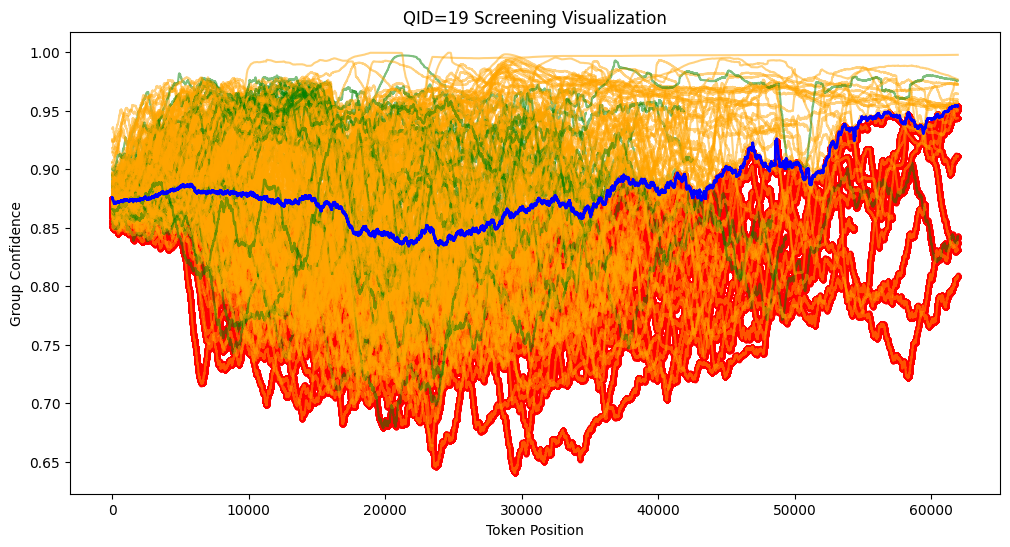

Confusion Matrix (rows=ground truth, columns=screening prediction):
[[213   0]
 [ 43   0]]


In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# --- 配置 ---
DATA_FILE = 'trace_data/aime_2025_19_full.jsonl'  # 所有 trace 数据
TARGET_QID = 19

# --- 载入函数 ---
def load_concatenated_json(file_path):
    decoder = json.JSONDecoder()
    data_parts = []
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
        idx = 0
        while idx < len(content):
            while idx < len(content) and content[idx].isspace():
                idx += 1
            if idx == len(content):
                break
            try:
                obj, end = decoder.raw_decode(content, idx)
                data_parts.append(obj)
                idx = end
            except json.JSONDecodeError:
                break
    if not data_parts:
        return None
    final_data = {k: v for k, v in data_parts[0].items() if k != 'traces'}
    all_traces = [trace for part in data_parts for trace in part.get('traces', [])]
    final_data['traces'] = all_traces
    final_data['num_traces'] = len(all_traces)
    return final_data

# --- 加载数据 ---
data = load_concatenated_json(DATA_FILE)
traces = data['traces']
if not traces:
    raise ValueError("No traces found!")

# --- 对齐 trace 长度 ---
max_len = max(len(trace['group_confidence']) for trace in traces)
all_conf_matrix = np.full((len(traces), max_len), np.nan)
labels = []
for i, trace in enumerate(traces):
    l = len(trace['group_confidence'])
    all_conf_matrix[i, :l] = trace['group_confidence']
    labels.append(1 if trace['is_correct'] else 0)

# --- 计算每个横坐标位置的 10% 分位数折线 ---
threshold_line = np.nanpercentile(all_conf_matrix, 40, axis=0)

# --- Screening ---
# 如果 trace 的任意点低于折线，则截掉低于折线的部分
pred_labels = []
plt.figure(figsize=(12, 6))
for i, trace in enumerate(traces):
    confs = np.array(trace['group_confidence'])
    correct = trace['is_correct']
    below_threshold = confs < threshold_line[:len(confs)]
    
    # 预测：如果 trace 被截掉，则认为删除，否则保留
    pred_label = 0 if np.any(below_threshold) else 1
    pred_labels.append(pred_label)
    
    # 绘图
    color = 'green' if correct else 'orange'
    plt.plot(confs, color=color, alpha=0.5)
    # 标红被截掉的部分
    if np.any(below_threshold):
        red_idx = np.where(below_threshold)[0]
        plt.scatter(red_idx, confs[red_idx], color='red', s=10)

# 绘制折线
plt.plot(threshold_line, color='blue', linewidth=2, label='10% Percentile Threshold')
plt.xlabel('Token Position')
plt.ylabel('Group Confidence')
plt.title(f'QID={TARGET_QID} Screening Visualization')
plt.show()

# --- 输出混淆矩阵 ---
cm = confusion_matrix(labels, pred_labels)
print("Confusion Matrix (rows=ground truth, columns=screening prediction):")
print(cm)


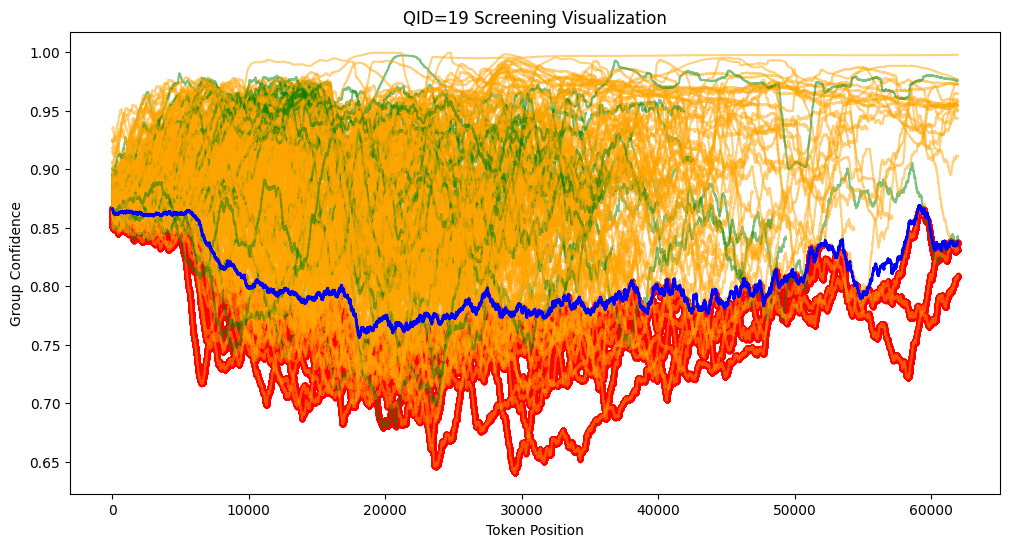

Confusion Matrix (rows=ground truth, columns=screening prediction):
[[177  36]
 [ 30  13]]


In [6]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# --- 配置 ---
DATA_FILE = 'trace_data/aime_2025_19_full.jsonl'  # 所有 trace 数据
TARGET_QID = 19

# --- 载入函数 ---
def load_concatenated_json(file_path):
    decoder = json.JSONDecoder()
    data_parts = []
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
        idx = 0
        while idx < len(content):
            while idx < len(content) and content[idx].isspace():
                idx += 1
            if idx == len(content):
                break
            try:
                obj, end = decoder.raw_decode(content, idx)
                data_parts.append(obj)
                idx = end
            except json.JSONDecodeError:
                break
    if not data_parts:
        return None
    final_data = {k: v for k, v in data_parts[0].items() if k != 'traces'}
    all_traces = [trace for part in data_parts for trace in part.get('traces', [])]
    final_data['traces'] = all_traces
    final_data['num_traces'] = len(all_traces)
    return final_data

# --- 加载数据 ---
data = load_concatenated_json(DATA_FILE)
traces = data['traces']
if not traces:
    raise ValueError("No traces found!")

# --- 对齐 trace 长度 ---
max_len = max(len(trace['group_confidence']) for trace in traces)
all_conf_matrix = np.full((len(traces), max_len), np.nan)
labels = []
for i, trace in enumerate(traces):
    l = len(trace['group_confidence'])
    all_conf_matrix[i, :l] = trace['group_confidence']
    labels.append(1 if trace['is_correct'] else 0)

# --- 计算每个横坐标位置的 10% 分位数折线 ---
threshold_line = np.nanpercentile(all_conf_matrix, 10, axis=0)

# --- Screening ---
# 如果 trace 的任意点低于折线，则截掉低于折线的部分
pred_labels = []
plt.figure(figsize=(12, 6))
for i, trace in enumerate(traces):
    confs = np.array(trace['group_confidence'])
    correct = trace['is_correct']
    below_threshold = confs < threshold_line[:len(confs)]
    
    # 预测：如果 trace 被截掉，则认为删除，否则保留
    pred_label = 0 if np.any(below_threshold) else 1
    pred_labels.append(pred_label)
    
    # 绘图
    color = 'green' if correct else 'orange'
    plt.plot(confs, color=color, alpha=0.5)
    # 标红被截掉的部分
    if np.any(below_threshold):
        red_idx = np.where(below_threshold)[0]
        plt.scatter(red_idx, confs[red_idx], color='red', s=10)

# 绘制折线
plt.plot(threshold_line, color='blue', linewidth=2, label='10% Percentile Threshold')
plt.xlabel('Token Position')
plt.ylabel('Group Confidence')
plt.title(f'QID={TARGET_QID} Screening Visualization')
plt.show()

# --- 输出混淆矩阵 ---
cm = confusion_matrix(labels, pred_labels)
print("Confusion Matrix (rows=ground truth, columns=screening prediction):")
print(cm)


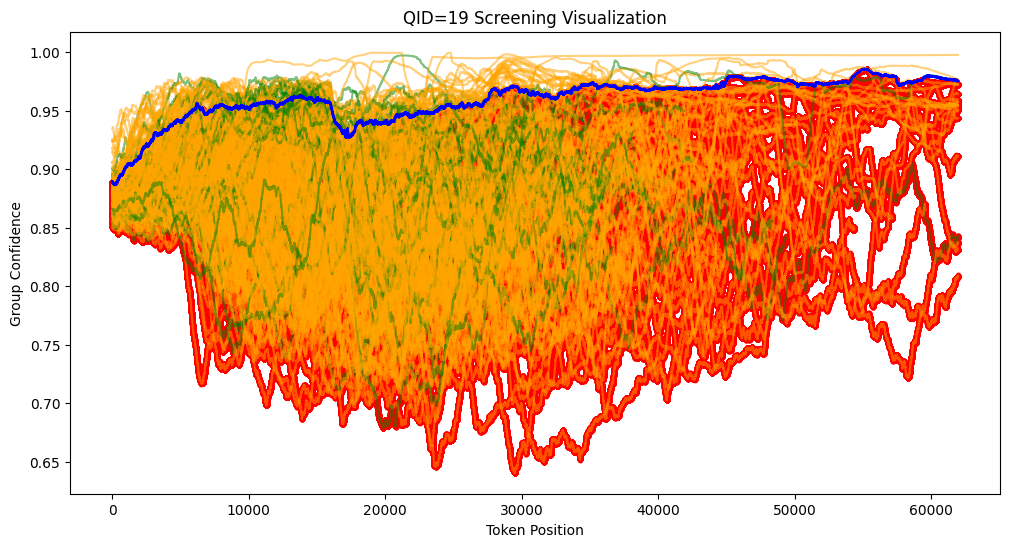

Confusion Matrix (rows=ground truth, columns=screening prediction):
[[213   0]
 [ 43   0]]


In [7]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# --- 配置 ---
DATA_FILE = 'trace_data/aime_2025_19_full.jsonl'  # 所有 trace 数据
TARGET_QID = 19

# --- 载入函数 ---
def load_concatenated_json(file_path):
    decoder = json.JSONDecoder()
    data_parts = []
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
        idx = 0
        while idx < len(content):
            while idx < len(content) and content[idx].isspace():
                idx += 1
            if idx == len(content):
                break
            try:
                obj, end = decoder.raw_decode(content, idx)
                data_parts.append(obj)
                idx = end
            except json.JSONDecodeError:
                break
    if not data_parts:
        return None
    final_data = {k: v for k, v in data_parts[0].items() if k != 'traces'}
    all_traces = [trace for part in data_parts for trace in part.get('traces', [])]
    final_data['traces'] = all_traces
    final_data['num_traces'] = len(all_traces)
    return final_data

# --- 加载数据 ---
data = load_concatenated_json(DATA_FILE)
traces = data['traces']
if not traces:
    raise ValueError("No traces found!")

# --- 对齐 trace 长度 ---
max_len = max(len(trace['group_confidence']) for trace in traces)
all_conf_matrix = np.full((len(traces), max_len), np.nan)
labels = []
for i, trace in enumerate(traces):
    l = len(trace['group_confidence'])
    all_conf_matrix[i, :l] = trace['group_confidence']
    labels.append(1 if trace['is_correct'] else 0)

# --- 计算每个横坐标位置的 10% 分位数折线 ---
threshold_line = np.nanpercentile(all_conf_matrix, 90, axis=0)

# --- Screening ---
# 如果 trace 的任意点低于折线，则截掉低于折线的部分
pred_labels = []
plt.figure(figsize=(12, 6))
for i, trace in enumerate(traces):
    confs = np.array(trace['group_confidence'])
    correct = trace['is_correct']
    below_threshold = confs < threshold_line[:len(confs)]
    
    # 预测：如果 trace 被截掉，则认为删除，否则保留
    pred_label = 0 if np.any(below_threshold) else 1
    pred_labels.append(pred_label)
    
    # 绘图
    color = 'green' if correct else 'orange'
    plt.plot(confs, color=color, alpha=0.5)
    # 标红被截掉的部分
    if np.any(below_threshold):
        red_idx = np.where(below_threshold)[0]
        plt.scatter(red_idx, confs[red_idx], color='red', s=10)

# 绘制折线
plt.plot(threshold_line, color='blue', linewidth=2, label='10% Percentile Threshold')
plt.xlabel('Token Position')
plt.ylabel('Group Confidence')
plt.title(f'QID={TARGET_QID} Screening Visualization')
plt.show()

# --- 输出混淆矩阵 ---
cm = confusion_matrix(labels, pred_labels)
print("Confusion Matrix (rows=ground truth, columns=screening prediction):")
print(cm)


In [13]:
np.argmax([1,0,0])

np.int64(0)

/home/yz54720/PY_envs/deepconf_py312/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


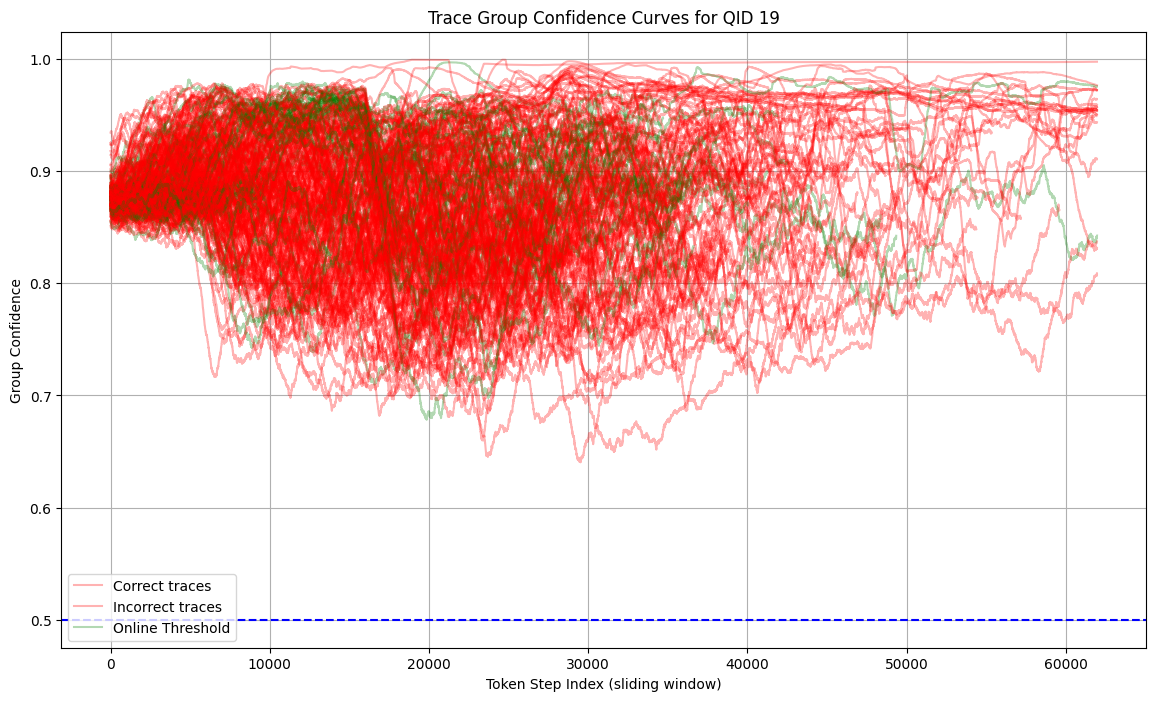

In [2]:
# --- 5. 可视化所有 trace 的 group confidence 曲线 ---
if traces:
    plt.figure(figsize=(14, 8))

    for trace in traces:
        gc = trace.get('group_confidence', [])
        if not gc: 
            continue
        label = 'Correct' if trace.get('is_correct', False) else 'Incorrect'
        # 用透明度区分，避免线条覆盖太密
        plt.plot(gc, alpha=0.3, color='green' if label == 'Correct' else 'red')

    plt.title(f"Trace Group Confidence Curves for QID {TARGET_QID}")
    plt.xlabel("Token Step Index (sliding window)")
    plt.ylabel("Group Confidence")
    plt.grid(True)
    plt.axhline(y=0.5, color='blue', linestyle='--', label="Example Online Threshold")
    plt.legend(['Correct traces', 'Incorrect traces', 'Online Threshold'])
    plt.show()
else:
    print("No traces to plot.")
